<a href="https://colab.research.google.com/github/nucontreras/3d-maze/blob/main/HW1_Nicol%C3%A1s_Contreras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><FONT size="8" color='264653'>Tarea 1: Redes Convolucionales </FONT>

><b><FONT size="5" color='DimGray'> IIC-3697 - Aprendizaje Profundo <p></FONT>
><b><FONT size="3" color='DimGray'> Fecha de Entrega: 8 de Mayo, 23:59</FONT>

><b><FONT size="3" color='SlateGray'> Alumno: Nicolás Contreras Pérez <p>
N° Alumno: 17642647 </FONT>

# <b><FONT size="5" color='MidnightBlue '>Connection to Google Drive </FONT>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd 'gdrive/MyDrive/Aprendizaje Profundo/HW1'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Aprendizaje Profundo/HW1


#<b><FONT size="5" color='MidnightBlue '>Install packages </FONT>



In [18]:
! pip install -q torchview
! pip install -q -U graphviz

In [ ]:
! pip install ultralytics

#<b><FONT size="5" color='MidnightBlue' id="import-of-packages">  Import of packages </FONT>



In [3]:
import os
import sys
import numpy as np

# Data processing and visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread

# AI packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

# from torchview import draw_graph
# import graphviz

In [ ]:
import ultralytics
ultralytics.checks()

In [ ]:
from ultralytics import YOLO

# <b><FONT color='MidnightBlue' size='5'>Clases y Funciones </FONT></b>

In [14]:
def plot_histogram_classes(class_count, dataset_name=None):
    # Obtener las etiquetas y los valores
    labels = list(class_count.keys())
    values = list(class_count.values())

    # Crear la figura con tamaño rectangular
    plt.figure(figsize=(8, 4))

    # Crear el histograma con el color #47b2ba
    plt.bar(labels, values, color='#47b2ba')

    # Ajustar el espaciado entre las etiquetas del eje x
    plt.xticks(rotation=45, ha='right')

    # Añadir etiquetas y título
    plt.xlabel('Clases')
    plt.ylabel('Frecuencia')
    if dataset_name:
        plt.title('Histograma de Frecuencia por Clase - ' + dataset_name)
    else:
        plt.title('Histograma de Frecuencia por Clase')

    # Mostrar el histograma
    plt.tight_layout()
    plt.show()

In [5]:
def count_classes(dataset):
    classes = full_dataset.classes
    class_count = {}
    for _, index in dataset:
        label = classes[index]
        if label not in class_count:
            class_count[label] = 0
        class_count[label] += 1
    return class_count

In [17]:
def show_one_image_per_class(classes, dataset):
    labels_map = {i: classes[i] for i in range(len(classes))}

    figure = plt.figure(figsize=(10, 4))
    cols, rows = 5, 2
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
    plt.show()

# <b><FONT color='MidnightBlue' size='6'>Parte 1: Pytorch + SimpleCNN </FONT></b>

## <b><FONT size="5" color='MidnightBlue '>Actividad 1</FONT>



En primer lugar, se obtiene el dataset [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html), previamente importada en la sección [Import of packages](#scrollTo=f8eg1lJrBW2J&line=1&uniqifier=1), mediante el método `datasets` de la librería `torchvision`.

In [8]:
full_dataset = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Tal como se menciona en [[1]](#scrollTo=pszVawT9y6pE), si `train=True`, crea el conjunto de datos a partir del conjunto de entrenamiento, y si `train=False`, lo crea a partir del conjunto de prueba. De esta forma, se guarda en la variable `full_dataset` los datos de entrenamiento y en la variable `cifar_testset` los datos de testing. Por otro lado, `download=True` descarga el conjunto de datos de Internet y lo coloca en el directorio raíz, mientras que `transform=` recibe una función/transformación que recibe una imagen de la librería`PIL` y devuelve una versión transformada de la imagen [[1]](#scrollTo=pszVawT9y6pE).

Se escoge la función `ToTensor()` para utilizar en `transform=`, la cual convierte una imagen cargada por la librería `PIL` o `ndarray` a tensor y escala los valores [[2]](#scrollTo=pszVawT9y6pE). Más específicamente, convierte una imagen (`PIL` o `numpy.ndarray`) `(H x W x C)`, donde `H` es la altura, `W` el ancho y `C` la cantidad de canales, en el rango [0, 255] a un `torch.FloatTensor` de forma (C x H x W) en el rango [0.0, 1.0] [[2]](#scrollTo=pszVawT9y6pE).

La conversión de la imagen se realiza si esta pertenece a uno de los modos (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) o si el `numpy.ndarray` tiene `dtype = np.uint8`. En los demás casos, los tensores se devuelven sin escalar [[2]](#scrollTo=pszVawT9y6pE).

Los tensores son objetos matemáticos que almacenan valores numéricos y que pueden tener distintas dimensiones [[3]](#scrollTo=pszVawT9y6pE). De esta forma,

El uso de tensores en Aprendizaje Profundo se debe principalmente ... GPU [[4]](#scrollTo=pszVawT9y6pE)



Explicar mi experiencia y la importancia de la conversión al realizar pos-procesamiento.

Debido a que la imagen de entrada se escala a [0.0, 1.0], esta transformación no debe utilizarse cuando se transforman máscaras de imagen de destino. Consulte las referencias para implementar las transformaciones para máscaras de imagen.




#<b><FONT color='MidnightBlue' size='6'>Referencias </FONT></b>

<a id="1">[1]</a>
Torch Contributors, “CIFAR10,” CIFAR10 - Torchvision 0.17 documentation, https://pytorch.org/vision/0.17/generated/torchvision.datasets.CIFAR10.html (accessed Apr. 19, 2024).

<a id="2">[2]</a>
Torch Contributors, “ToTensor,” ToTensor - Torchvision main documentation, https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html (accessed Apr. 19, 2024).

<a id="3">[3]</a>
A. Krizhevsky, “The CIFAR-10 dataset,” CIFAR-10 and CIFAR-100 datasets, https://www.cs.toronto.edu/%7Ekriz/cifar.html (accessed Apr. 19, 2024).

<a id="4">[4]</a>
P. Recuero de los Santos, “Deep learning para todos los públicos: ¿Qué son los tensores? ¿Qué es tensorflow?,” Deep Learning para todos los públicos: ¿Qué son los tensores? ¿Qué es TensorFlow?, https://telefonicatech.com/blog/deep-learning-para-todos-los-publicos (accessed Apr. 19, 2024).

<a id="5">[5]</a>
S. Lozada, “Tensores Pytorch,” Medium, https://medium.com/latinxinai/tensores-pytorch-ea4ce8ce96dc (accessed Apr. 19, 2024).

<a id="6">[6]</a>

<a id="7">[7]</a>

<a id="8">[8]</a>

<a id="9">[9]</a>

<a id="10">[10]</a>

<a id="11">[11]</a>

In [20]:
classes = full_dataset.classes
print(len(classes))
classes

10


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
print(len(full_dataset))
print(len(cifar_testset))

50000
10000


In [11]:
full_dataset_classes = count_classes(full_dataset)
cifar_testset_classes = count_classes(cifar_testset)

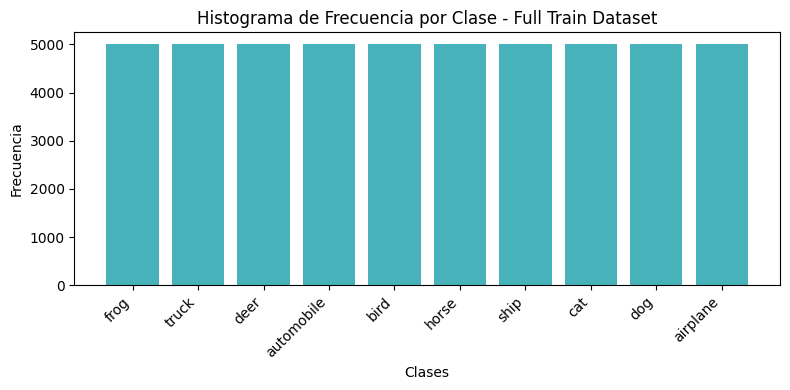

In [15]:
plot_histogram_classes(full_dataset_classes, 'Full Train Dataset')

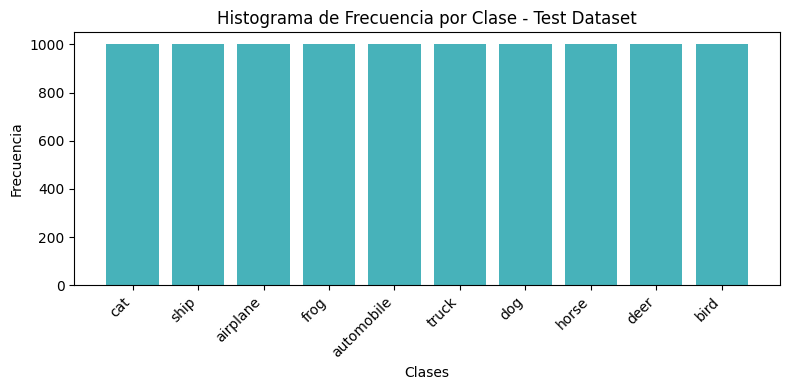

In [16]:
plot_histogram_classes(cifar_testset_classes, 'Test Dataset')

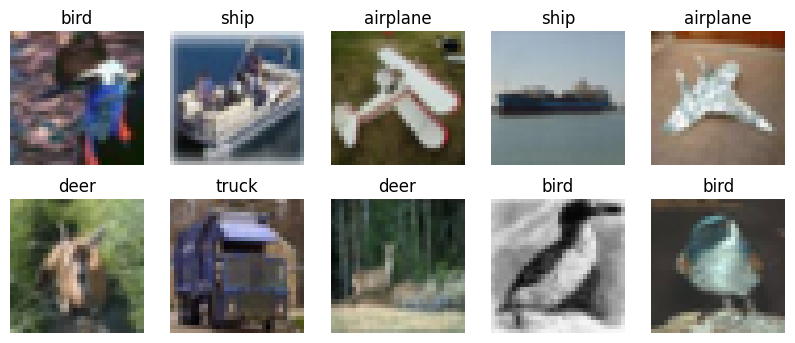

In [18]:
show_one_image_per_class(classes, full_dataset)

Importancia de la separación:

De acuerdo con las directrices del documento propuesto, se ha llevado a cabo una separación de la base de datos en tres conjuntos tradicionales: formación, validación y prueba. La importancia de esta separación radica en la necesidad de evaluar y mejorar el rendimiento del modelo de forma objetiva y fiable. Además, tal y como se indica en el apartado \hyperref[sec:preliminaries]{\ref{sec:preliminaries} Preliminares}, al no existir un conjunto de validación, se añade, con el fin de dar una estimación no sesgada de la competencia del modelo final ajustado a la hora de comparar o seleccionar entre modelos finales \cite{porque-validacion}.

Traducción realizada con la versión gratuita del traductor www.DeepL.com/Translator

https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/

Separación porcentajes :

La divisi´on de datos entre los distintos sets se ha hecho de forma aleatoria y se puede ver en
las im´agenes 2 y 3. En general, colocar el 80% de los datos en el conjunto de entrenamiento,
el 10% en el conjunto de validaci´on y el 10% en el conjunto de prueba es una buena divisi´on
para empezar [1].

https://www.v7labs.com/blog/train-validation-test-set

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [29]:
cifar_trainset_classes

{'frog': 4480,
 'deer': 4506,
 'horse': 4502,
 'automobile': 4528,
 'dog': 4490,
 'truck': 4520,
 'cat': 4466,
 'bird': 4502,
 'airplane': 4495,
 'ship': 4511}

In [ ]:
batch_size=128

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=100, shuffle=False)

* ¿Que hace el parámetro shuffle en los DataLoaders de Pytorch, debemos usarlos para ambos datasets? ¿Por qué?

* ¿Que podemos ver de las distribuciones? ¿Cuál es el impacto del balance de una base de datos en Deep Learning y Computer Vision (CV)?

Texto [[20]](#20).

https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54

https://medium.com/analytics-vidhya/classifying-cifar-10-using-a-simple-cnn-4e9a6dd7600b



https://www.datascienceweekly.org/tutorials/cifar10-pytorch-load-cifar10-dataset-from-torchvision


https://pytorch.org/vision/0.17/generated/torchvision.datasets.CIFAR10.html

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://pytorch.org/docs/stable/generated/torch.squeeze.html#torch.squeeze

https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch

https://www.geeksforgeeks.org/implementation-of-a-cnn-based-image-classifier-using-pytorch/

https://www.analyticsvidhya.com/blog/2021/09/convolutional-neural-network-pytorch-implementation-on-cifar10-dataset/



## <b><FONT size="5" color='MidnightBlue '>Actividad 2</FONT>



In [19]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #Input = 3 x 32 x 32, Output = 6 x 28 x 28
            torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 0),
            torch.nn.ReLU(),
            #Input = 6 x 28 x 28, Output = 6 x 14 x 14
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2),

            #Input = 6 x 14 x 14, Output = 16 x 10 x 10
            torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            torch.nn.ReLU(),
            #Input = 16 x 10 x 10, Output = 16 x 5 x 5
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2),

            torch.nn.Flatten(),
            torch.nn.Linear(16 * 5 * 5, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.model(x)

In [20]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN().to(device)

In [21]:
print(model)

SimpleCNN(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [35]:
model_graph_1 = draw_graph(
    SimpleCNN(), input_size=(1, 3, 32, 32),
    graph_name='SimpleCNN',
    hide_inner_tensors=False,
    hide_module_functions=False,
    expand_nested=True
)

In [31]:
model_graph_1.resize_graph(scale=0.5)

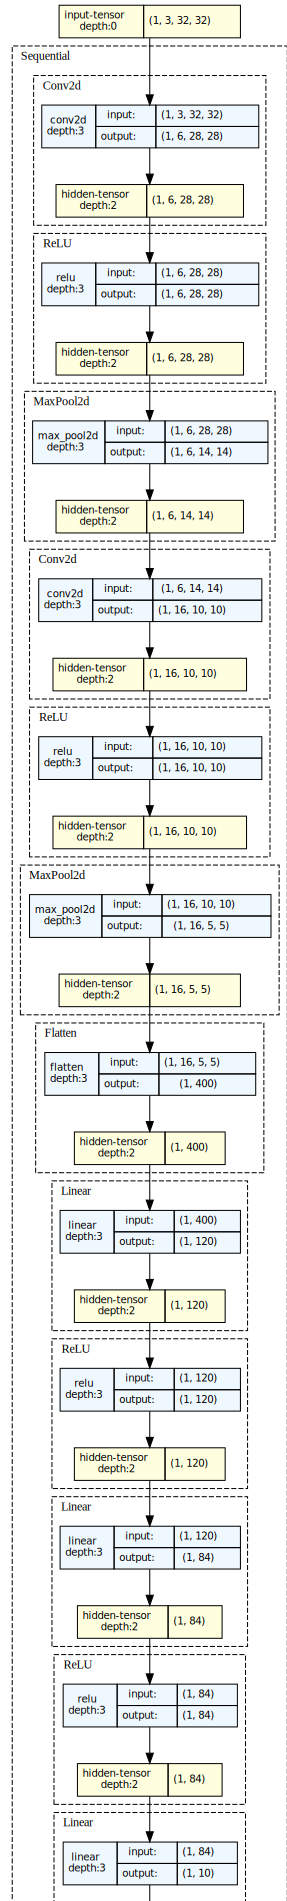

In [36]:
model_graph_1.visual_graph

* ¿Qué es el Max Pooling? ¿Para qué lo utilizamos en CNN?


* ¿Qué ventajas tiene usar ReLU en vez de una función de activación Sigmoide?



https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6

https://github.com/mert-kurttutan/torchview


## <b><FONT size="5" color='MidnightBlue '>Actividad 3</FONT>



https://machinelearningmastery.com/using-optimizers-from-pytorch/


# <b><FONT color='MidnightBlue' size='6'>Parte 2: ResNet18 </FONT></b>

## <b><FONT size="5" color='MidnightBlue '>Actividad 4</FONT>



https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch

https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

## <b><FONT size="5" color='MidnightBlue '>Actividad 5</FONT>



## <b><FONT size="5" color='MidnightBlue '>Actividad 6</FONT>



#<b><FONT color='MidnightBlue' size='6'>Parte 3: Image Segmentation + YOLO </FONT></b>

## <b><FONT size="5" color='MidnightBlue '>Actividad 7</FONT>



In [ ]:
pre_trained_model = YOLO('yolov8s-seg.pt')

¿Por qué utilizamos modelos pre-entrenados (pretrained)? ¿Cuáles son las ventajas y desventajas?



## <b><FONT size="5" color='MidnightBlue '>Actividad 8</FONT>



## <b><FONT size="5" color='MidnightBlue '>Actividad 9</FONT>



# <b><FONT color='MidnightBlue' size='5'>Trash </FONT></b>

In [ ]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
return class_count

In [ ]:
# for a, index in full_dataset:
#     print(index)
type(full_dataset)

torchvision.datasets.cifar.CIFAR10

In [ ]:
torch.manual_seed(43)
val_size = 5000
train_size = len(full_dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
cifar_trainset_classes = count_classes(train_ds)
cifar_valset_classes = count_classes(val_ds)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# Get indices for training_set and validation_set
n_train = len(full_dataset)
# Percentage of training set to use as validation
n_valid = 0.2
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_sampler

In [ ]:
cifar_trainset_classes = count_classes(train_sampler)
# cifar_valset_classes = count_classes(val_ds)


TypeError: cannot unpack non-iterable int object

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, pin_memory=True)